In [1]:
from spikingjelly.activation_based.neuron import ParametricLIFNode, LIFNode, BaseNode, IFNode, AdaptBaseNode, NonSpikingIFNode, NonSpikingLIFNode
from spikingjelly.activation_based.layer import Linear, SynapseFilter, PrintShapeModule
from spikingjelly.activation_based.base import MemoryModule
from spikingjelly.activation_based.surrogate import LeakyKReLU, MultiArgsSurrogateFunctionBase, ATan, Sigmoid
from spikingjelly.activation_based.functional import set_step_mode
from spikingjelly.activation_based.monitor import OutputMonitor
from jaxtyping import Float, Int64
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import wandb
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.activation_based import surrogate, neuron, functional
from typing import Callable, Any, overload
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from utils.datasets import generate_lp_dataset, generate_cosine_dataset, encode_temporal

In [2]:
cfg = dict(
    NUM_SAMPLES = 10000,  # 총 10000 개의 샘플 생성
    VECTOR_DIM = 1,      # 각 벡터는 1차원
    MAX_VAL = 10.0,
    TIME_STEPS = 23,     # SNN을 23 타임스텝 동안 실행
    BATCH_SIZE = 64,
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
rng = torch.manual_seed(42)

In [4]:
import torch

class StochasticRound(torch.autograd.Function):
    """
    확률적 라운딩 (Stochastic Rounding)을 위한 Straight-Through Estimator (STE)
    
    - Forward Pass:  입력 x를 floor(x) 또는 ceil(x)로 확률적으로 붕괴시킴.
                     P(ceil(x)) = x - floor(x)
                     P(floor(x)) = 1 - (x - floor(x))
    - Backward Pass: 그래디언트를 1로 그대로 통과시킴 (Identity).
    """
    
    @staticmethod
    def forward(ctx, x: torch.Tensor) -> torch.Tensor:
        """
        Forward Pass: 확률적 라운딩 수행
        """
        # 1. floor 값과 ceil 확률(p) 계산
        #    (예: x=2.7 -> x_floor=2.0, p=0.7)
        x_floor = torch.floor(x)
        p = x - x_floor  # ceil(x)가 될 확률
        
        # 2. 확률적 붕괴
        # r < p (이 이벤트는 p의 확률로 발생) 이면 ceil(x) = x_floor + 1
        # 아니면 (1-p의 확률로 발생) floor(x)
        rounded_x = torch.where(torch.bernoulli(p).bool(), x_floor + 1.0, x_floor)
        
        return rounded_x.long()

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """
        Backward Pass (STE):
        그래디언트를 그대로 통과시킴
        """
        # (d_loss / d_rounded_x) * (d_rounded_x / d_x)
        # STE는 d_rounded_x / d_x 를 1로 가정함
        return grad_output

In [5]:
class TransposeLayer(torch.nn.Module):
    dims: tuple[int, int]

    def __init__(self, dims: tuple[int, int]) -> None:
        super().__init__()
        self.dims = dims

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input.transpose(*self.dims)

class SynapticDelayConvolution(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input: torch.Tensor, delay: torch.nn.Parameter) -> torch.Tensor:
        """Apply synaptic delay to the one-hot coded input tensor.
        
        :param ctx: 설명
        :param input: The input tensor to apply delay to. shape: (T, N, C, D_out, D_in)
        :type input: torch.Tensor
        :param delay: The delay tensor to apply. shape: (D_out, D_in)
        :type delay: torch.nn.Parameter
        :return: The output tensor after applying synaptic delay. shape: (T, N, C, D_out, D_in)
        :rtype: Tensor
        """
        output = input.clone()
        T, N, C, D_out, D_in = output.shape
        rounded_delay:Int64[Tensor, "N C D_out D_in"] = StochasticRound.apply(delay[None,None,...].repeat(N, C, 1, 1)) # type: ignore
        rounded_delay = rounded_delay.clamp(max= (T - 1) - output.argmax(dim=0))
            # (T-1) is the last timestep, argmax to indicate spike time

        mat = torch.arange(T, device=output.device).view(T,1,1,1,1).repeat(1,N,C,D_out,D_in)
        output = torch.gather(output, 0, (mat - rounded_delay[None,...]) % T)
        # for n in range(N):
        #     for c in range(C):
        #         for d_out in range(D_out):
        #             for d_in in range(D_in):
        #                 output[:, n, c, d_out, d_in] = output[:, n, c, d_out, d_in].roll(int(rounded_delay[n, c, d_out, d_in]), dims=0)

        # ctx.save_for_backward(output, rounded_delay)
        
        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """
        Backward Pass (STE): 'delay'에 대한 가짜 그래디언트를 계산하여 반환
        
        grad_output: Loss에 대한 shifted_vec의 그래디언트 (d_loss / d_shifted_vec)
        """
        
        #TODO: Gradient of clamped delay?
        # output, delay = ctx.saved_tensors
        # T, N, C, D_in, D_out = output.shape
        
        # 'delay'에 대한 그래디언트만 계산 (vec의 그래디언트는 None)
        grad_delay = None
        
        # 'delay'가 그래디언트를 요구할 때만 (needs_input_grad[1]) 계산
        if ctx.needs_input_grad[1]:
            grad_delay = grad_output.sum(dim=(0, 1, 2))
        
        # vec의 그래디언트(None), d의 그래디언트 순서로 반환
        return None, grad_delay

class SDCLinear(torch.nn.Module):
    def __init__(self, out_features: int, tau: float = 2., bias = False) -> None:
        super().__init__()
        self.in_features = 2
        self.out_features = out_features
        self.bias = bias
        self._delay = torch.nn.Parameter((torch.arange(1, out_features + 1).view(-1, 1).float()), requires_grad=False) # For symmetry
        self.weight = torch.nn.Parameter(torch.tensor(3).exp()) # For symmetry
        # if bias:
        #     self.log_bias = torch.nn.Parameter(torch.tensor(0.))

        self.filter = SynapseFilter(tau=tau, learnable=False, step_mode="m")
        self._loss = None

    def extra_repr(self):
        return f'in_features={self.in_features}, out_features={self.out_features}'
    
    @property
    def delay(self):
        return torch.cat([self._delay.relu(), (self.out_features - self._delay).relu()], dim=1)

    def forward(self, input: torch.Tensor, reset: bool=True) -> torch.Tensor:
        if reset:
            self.filter.reset()
        
        output = input.unsqueeze(-2).repeat([1] * (len(input.shape) - 1) + [self.out_features, 1]) # ..., 2 -> ..., d_out, 2
        output = SynapticDelayConvolution.apply(output, self.delay); assert isinstance(output, torch.Tensor)
        output = self.filter(output)
        output.mul_(self.weight)
        output = output.sum(dim=-1)
        # if self.bias:
        #     output += self.log_bias.exp()

        return output


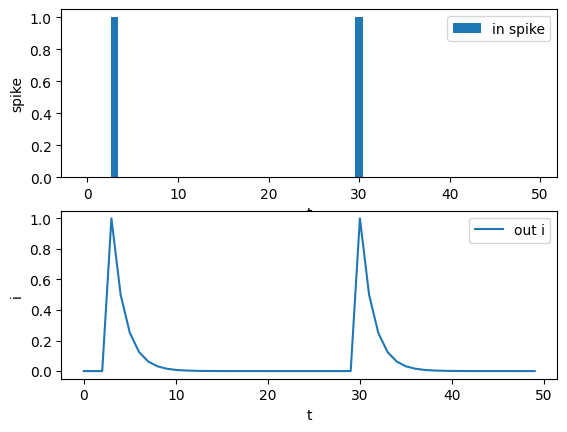

In [6]:
T = 50
in_spikes = (torch.rand(size=[T]) >= 0.95).float()
lp_syn = SynapseFilter(tau=1+1)
plt.subplot(2, 1, 1)
plt.bar(torch.arange(0, T).tolist(), in_spikes, label='in spike')
plt.xlabel('t')
plt.ylabel('spike')
plt.legend()

out_i = []
for i in range(T):
    out_i.append(lp_syn(in_spikes[i]))
plt.subplot(2, 1, 2)
plt.plot(out_i, label='out i')
plt.xlabel('t')
plt.ylabel('i')
plt.legend()
plt.show()

In [7]:
class CCN(torch.nn.Module):
    def __init__(self,
                 vector_dim:int,
                 cc_acc:int,
                 feature_dims:list[int],
                 step_mode:str = "m",
                 backend:str = "torch",
                 neuron:type[BaseNode] = LIFNode,
                 surrogate:type[MultiArgsSurrogateFunctionBase] = ATan):
        """
        Cross-correlation network initialization.
        
        :param self: 설명
        :param input_dim: ...
        :param n_acc: 설명
        """
        super(CCN, self).__init__()
        self.vector_dim = vector_dim
        self.cc_acc = cc_acc
        self.feature_dims = feature_dims
        self.step_mode = step_mode
        self.backend = backend
        self.neuron = neuron
        self.surrogate = surrogate
        
        self.model = torch.nn.Sequential(
            TransposeLayer((2,3)), # T,N,2,D -> T,N,D,2
            SDCLinear(cc_acc, tau=2., bias=True), # T,N,D,2 -> T,N,D,cc_acc
            neuron(tau=2., v_reset=0., surrogate_function=surrogate(), backend=backend, store_v_seq=True, step_mode="m"), # T,N,D,cc_acc -> T,N,D,cc_acc
            
            # # SynapseFilter(tau=10.0, step_mode="m", learnable=True), # T,N,D,cc_acc -> T,N,D,cc_acc
            # Linear(cc_acc, 1, step_mode="m"), # T,N,D,cc_acc -> T,N,D,1
            torch.nn.Flatten(start_dim=2), # T,N,D,1 -> T,N,D
            # neuron(v_reset=0., step_mode="m", backend="cupy"), # T,N,D -> T,N,D
        )

        feature_dims = [self.vector_dim * self.cc_acc] + self.feature_dims
        for in_dim, out_dim in zip(feature_dims[:-1], feature_dims[1:]):
            self.model.extend(
                [
                    # SynapseFilter(tau=10.0, step_mode="m", learnable=True), # T,N,D,cc_acc -> T,N,D,cc_acc
                    Linear(in_dim, out_dim),
                    neuron(v_reset=0., surrogate_function=surrogate(), backend=self.backend)
                ]
            )
        
        self.linear = Linear(feature_dims[-1], 1)
        self.out_neuron = NonSpikingIFNode()
        
        set_step_mode(self, step_mode)
        self.stats = OutputMonitor(self, (neuron, SynapseFilter))
        
        self._loss = None
    
    @property
    def loss(self):
        if self._loss is not None:
            return self._loss
        else:
            raise ValueError("Loss has not been computed yet.")
    
    def forward(self, x:Float[Tensor, "T N 2D"], reset:bool=True, v_seq_pt:list=[]):
        """
        Compute the correlation between two input tensors.
        
        :param self: 설명
        :param x: 설명
        :type x: torch.Tensor
        """
        if reset:
            for layer in self.model:
                if isinstance(layer, (BaseNode, MemoryModule)):
                    layer.reset()
            
        for i, layer in enumerate(self.model):
            x = layer(x)
            # if i == 2:
            #     self._loss = x.mean(dim=(0,-1)) - 0.25
            #     self._loss = x.square().mean()
        
        x = self.linear(x)
        x = self.out_neuron(x)
        
        v_seq_pt.append(self.model[2].v_seq)

        return x


In [8]:
NUM_SAMPLES = cfg["NUM_SAMPLES"]  # 총 1000 개의 샘플 생성
VECTOR_DIM = cfg["VECTOR_DIM"]      # 각 벡터는 3차원
MAX_VAL = cfg["MAX_VAL"]
TIME_STEPS = cfg["TIME_STEPS"]     # SNN을 16 타임스텝 동안 실행
BATCH_SIZE = cfg["BATCH_SIZE"]

model = CCN(vector_dim = VECTOR_DIM, cc_acc=TIME_STEPS-1, feature_dims=[]).to(device)
model

  (model): Sequential(
    (0): TransposeLayer()
    (1): SDCLinear(
      in_features=2, out_features=22
      (filter): SynapseFilter(tau=2.0, learnable=False, step_mode=m)
    )
    (2): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): Flatten(start_dim=2, end_dim=-1)
  )
  (linear): Linear(in_features=22, out_features=1, bias=True)
  (out_neuron): NonSpikingIFNode()
), which is not spikingjelly.activation_based.base.StepModule


CCN(
  (model): Sequential(
    (0): TransposeLayer()
    (1): SDCLinear(
      in_features=2, out_features=22
      (filter): SynapseFilter(tau=2.0, learnable=False, step_mode=m)
    )
    (2): LIFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch, tau=2.0
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (3): Flatten(start_dim=2, end_dim=-1)
  )
  (linear): Linear(in_features=22, out_features=1, bias=True)
  (out_neuron): NonSpikingIFNode()
)

In [9]:
X_data, y_data = generate_cosine_dataset(NUM_SAMPLES, VECTOR_DIM, max_val=MAX_VAL)
X_data = torch.stack([torch.FloatTensor(encode_temporal(X_data[:,0,:], TIME_STEPS)),
                      torch.FloatTensor(encode_temporal(X_data[:,1,:], TIME_STEPS))],
                     dim=2) # T N 2D
y_data = torch.FloatTensor(y_data) / y_data.max() # N D
dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # T N 2D -> N T 2D

train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120 * (NUM_SAMPLES // BATCH_SIZE))
loss = torch.tensor(float("inf"))

pbar = tqdm(range(120))
pred_hist, target_hist, err_hist = [], [], []
# wandb_table = wandb.Table(columns=[f"v_{t}" for t in range(TIME_STEPS)], log_mode="INCREMENTAL")
with wandb.init(project="DelayedTemporal",
                config=cfg) as run:
    for epoch in pbar:
        model.train()
        for i, batch in enumerate(tqdm(train_loader, leave=False)):
            inputs:Float[Tensor, "N T 2 D"]; targets:Float[Tensor, "N D"]
            inputs, targets = batch
            inputs = inputs.to(device); targets = targets.to(device)
            # 모델 학습 코드 추가
            v_seq_pt = []
            out = model(inputs.transpose(1, 0), v_seq_pt=v_seq_pt) # N T 2 D -> T N 2 D -> model -> N D
            loss = criterion(out, targets) #+ model.loss
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            v_seq = v_seq_pt[-1]
            pbar.set_postfix({"loss": loss.item(), "scale":(out.max()-out.min()).item()})
            if i % 10 == 0:
                # wandb_table.add_data(*v_seq.mean(dim=(1,2,3)).tolist())
                run.log({"loss": loss.item(),
                        "err":(out - targets).abs().mean().item(),
                        "model.2 rate": model.stats['model.2'][-1].mean(),})
                for t in range(TIME_STEPS):
                    run.log({
                        f"model.2 mem_{i}": v_seq[t,0,0,i] for i in range(v_seq.shape[-1])
                    })
        scheduler.step()
        
        with torch.no_grad():
            model.eval()
            for batch in tqdm(test_loader, leave=False):
                inputs, targets = batch
                inputs = inputs.to(device); targets = targets.to(device)
                # 모델 학습 코드 추가
                out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
                
                loss = criterion(out, targets)
                pred_hist.extend(out.squeeze().tolist())
                target_hist.extend(targets.squeeze().tolist())
                err_hist.extend((out.squeeze() - targets.squeeze()).abs().tolist())
                pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})

  0%|          | 0/120 [00:00<?, ?it/s]

wandb: Currently logged in as: sizzflair97 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


  0%|          | 0/125 [00:00<?, ?it/s]

/opt/conda/envs/dt/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/32 [00:00<?, ?it/s]

/opt/conda/envs/dt/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

err,█▇▄▄▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model.2 mem_0,█▆▁▆▁▁▁▁▄▄▁▁▁▃▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁
model.2 mem_1,▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
model.2 mem_10,▁█▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
model.2 mem_11,▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▆▁▁▁▁▁▁
model.2 mem_12,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄
model.2 mem_13,▁▁█▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁
model.2 mem_14,▁█▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
model.2 mem_15,▁▁▁▁▁▁█▁▁▁▁▁▁▁▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
+15,...


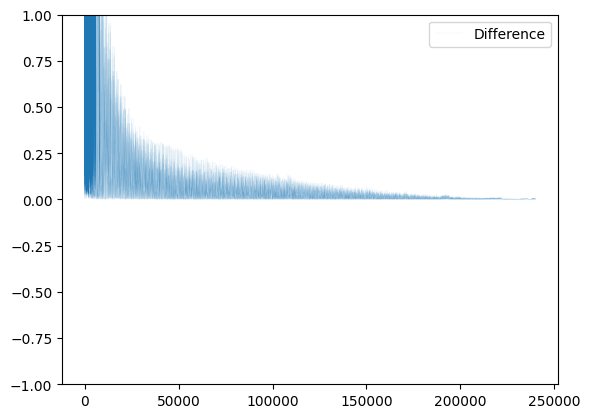

In [10]:
plt.plot(err_hist, linewidth=0.02, label="Difference")
plt.ylim(-1, 1)
plt.legend()

In [11]:
a = torch.cat(model.stats['model.2'], dim=1)

In [12]:
a.shape

torch.Size([23, 1200000, 1, 22])

In [13]:
b = torch.cat(model.stats['model.1.filter'], dim=1)

In [14]:
b.shape

torch.Size([23, 1200000, 1, 22, 2])

In [15]:
b[:, 0, 0, 0, :]

tensor([[0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00],
        [2.0086e+01, 0.0000e+00],
        [1.0043e+01, 0.0000e+00],
        [5.0214e+00, 0.0000e+00],
        [2.5107e+00, 0.0000e+00],
        [1.2553e+00, 0.0000e+00],
        [6.2767e-01, 0.0000e+00],
        [3.1384e-01, 0.0000e+00],
        [1.5692e-01, 0.0000e+00],
        [7.8459e-02, 0.0000e+00],
        [3.9230e-02, 0.0000e+00],
        [1.9615e-02, 0.0000e+00],
        [9.8074e-03, 0.0000e+00],
        [4.9037e-03, 0.0000e+00],
        [2.4518e-03, 0.0000e+00],
        [1.2259e-03, 0.0000e+00],
        [6.1296e-04, 2.0086e+01]], device='cuda:0', grad_fn=<SelectBackward0>)

In [16]:
for t in a.sum(dim=(1,2,3))[:]:
    print(t.detach().cpu().numpy())

55440.0
222360.0
498840.0
878400.0
1.3134e+06
1.74504e+06
2.17704e+06
2.61216e+06
3.04776e+06
3.48696e+06
3.92472e+06
4.3656e+06
4.78728e+06
5.17236e+06
5.53224e+06
5.89344e+06
6.2514e+06
6.59724e+06
6.96624e+06
7.33488e+06
7.68792e+06
8.0586e+06
2.474112e+07


In [17]:
sample = dataset[0:50]
inputs, targets = sample
inputs = inputs.to(device); targets = targets.to(device)
out = model(inputs.transpose(1, 0))